In [1]:
from time import time
import numpy as np
import pandas as pd
import math
from tqdm import tqdm

import zipfile, os, cv2
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras import layers, callbacks, utils

import imgaug as ia
from imgaug import augmenters as iaa

from scipy.io import savemat, loadmat
from PIL import Image
from os import path
from keras.callbacks import ModelCheckpoint

# from image2RLE import dctImage

import matplotlib.pyplot as plt
import seaborn as sns
from numpy import newaxis
sns.set_style('darkgrid')

from os import path,listdir

**Data Preparation**

In [2]:
path_zip = '../input/denoising-dirty-documents/'
path = '/kaggle/working/'

with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
    
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

**JPeg Proposed Code**

In [3]:
class config():
#     IMG_SIZE = (240, 240)
#     IMG_SIZE = (256, 256)
#     IMG_SIZE = (512, 512)
#     IMG_SIZE = (420, 540)
    IMG_SIZE = (1024, 1024)

In [4]:
# defining block size
block_size = 8
# Quantization Matrix 
# https://stackoverflow.com/questions/29215879/how-can-i-generalize-the-quantization-matrix-in-jpeg-compression
QUANTIZATION_MAT = np.array(
    [[6,  4,  4,  6,  10, 16, 20, 24],
     [5,  5,  6,  8,  10, 23, 24, 22],
     [6,  5,  6,  10, 16, 23, 28, 22],
     [6,  7,  9,  12, 20, 35, 32, 25],
     [7,  9,  15, 22, 27, 44, 41, 31],
     [10, 14, 22, 26, 32, 42, 45, 37],
     [20, 26, 31, 35, 41, 48, 48, 40],
     [29, 37, 38, 39, 45, 40, 41, 40]])


def dctImage(img):
    # get size of the image
    [h, w] = img.shape

    # No of blocks needed : Calculation

    height = h
    width = w
    h = np.float32(h)
    w = np.float32(w)

    nbh = math.ceil(h / block_size)
    nbh = np.int32(nbh)

    nbw = math.ceil(w / block_size)
    nbw = np.int32(nbw)

    H = block_size * nbh

    # width of padded image
    W = block_size * nbw
    padded_img = np.zeros((H, W))

    padded_img[0:height, 0:width] = img[0:height, 0:width]

    for i in range(nbh):

        # Compute start and end row index of the block
        row_ind_1 = i * block_size
        row_ind_2 = row_ind_1 + block_size

        for j in range(nbw):
            # Compute start & end column index of the block
            col_ind_1 = j * block_size
            col_ind_2 = col_ind_1 + block_size

            block = padded_img[row_ind_1: row_ind_2, col_ind_1: col_ind_2]

            # apply 2D discrete cosine transform to the selected block
            DCT = cv2.dct(block)

            DCT_normalized = np.divide(DCT, QUANTIZATION_MAT).astype(int)

            padded_img[row_ind_1: row_ind_2, col_ind_1: col_ind_2] = DCT_normalized
            # cv2.imwrite('out.bmp', np.uint8(padded_img))
    return padded_img


def idctImage(img):
    [h, w] = img.shape
    padded_img = np.zeros((h, w), np.float32)
    for i in range(0, h, 8):
        # Compute start and end row index of the block
        row_ind_1 = i * block_size
        row_ind_2 = row_ind_1 + block_size

        for j in range(0, w, 8):
            block = img[i:i+8,j:j+8]
            DCT_normalized = np.multiply(block, QUANTIZATION_MAT).astype(int)

            DCT = cv2.idct(DCT_normalized.astype(np.float32))

            padded_img[i:i+8,j:j+8] = DCT

    return padded_img

In [5]:
class DCT_DataGen(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,ImagePath,MaskPath,list_IDs, labels=None, batch_size=10, dim=(512,512), n_channels=1,
                 n_classes=1, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.ImagePath = ImagePath
        self.MaskPath = MaskPath
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]

        # Generate data
        X, Y= self.__data_generation(list_IDs_temp, labels_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp, labels_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        Y = np.empty((self.batch_size, *self.dim, self.n_classes))

        # Generate data
        for i, (ID, label) in enumerate(zip(list_IDs_temp, labels_temp)):
            # Store sample
            img = Image.open(self.ImagePath+ID).convert("L").resize((self.dim[1],self.dim[0]))
            img = np.array(img)
#             x,y,z = img.shape
            dctOut = dctImage(img)
            dctOut = np.expand_dims(dctOut, axis=2)
            X[i,] = dctOut
#             img = np.array( Image.open(path.join(self.MaskPath,label)).resize((self.dim[1],self.dim[0])))[:,:,0]
            
            
            mask = Image.open(self.MaskPath+ID).convert("L").resize((self.dim[1],self.dim[0]))
            mask = np.array(mask)/255
            mask = np.expand_dims(mask, axis=2)
            Y[i,] = mask
        return X, Y

In [6]:
from os import listdir
from sklearn.model_selection import train_test_split
ImagePath="./train/"
MaskPath='./train_cleaned/'
dct_ids = listdir(ImagePath)
mask_ids = listdir(MaskPath)
train_dct_ids, val_dct_ids, train_mask_ids, val_mask_ids = train_test_split(dct_ids, mask_ids, test_size = 0.15)

In [7]:
# dataset = DCT_DataGen(ImagePath=ImagePath,MaskPath=MaskPath,list_IDs=train_dct_ids,labels=train_mask_ids,dim=(256, 256),batch_size=2)
# valDataset = DCT_DataGen(ImagePath=ImagePath,MaskPath=MaskPath,list_IDs=val_dct_ids,labels=val_mask_ids,dim=(256, 256),batch_size=2)
# len(dataset),len(valDataset)
# dataset = DCT_DataGen(ImagePath=ImagePath,MaskPath=MaskPath,list_IDs=train_dct_ids,labels=train_mask_ids,dim=(512,512),batch_size=2)
# valDataset = DCT_DataGen(ImagePath=ImagePath,MaskPath=MaskPath,list_IDs=val_dct_ids,labels=val_mask_ids,dim=(512,512),batch_size=2)
dataset = DCT_DataGen(ImagePath=ImagePath,MaskPath=MaskPath,list_IDs=train_dct_ids,labels=train_mask_ids,dim=(1024,1024),batch_size=2)
valDataset = DCT_DataGen(ImagePath=ImagePath,MaskPath=MaskPath,list_IDs=val_dct_ids,labels=val_mask_ids,dim=(1024,1024),batch_size=2)

In [8]:
for x,y in dataset:
    print(y.shape)
    break

(2, 1024, 1024, 1)


In [9]:
class DenoisingAutoencoder(Model):
  def __init__(self, act):
    self.act = act;
    super(DenoisingAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(*config.IMG_SIZE, 1)), 
        layers.Conv2D(48, (3, 3), activation=self.act, padding='same'),
        layers.Conv2D(72, (3, 3), activation=self.act, padding='same'),
        layers.Conv2D(144, (3, 3), activation=self.act, padding='same'),
        layers.Conv2D(180, (3, 3), activation=self.act, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Dropout(0.3),
#         layers.Dropout(0.5),
    ])

    self.decoder = tf.keras.Sequential([
        layers.Conv2D(180, (3, 3), activation=self.act, padding='same'),
        layers.Conv2D(144, (3, 3), activation=self.act, padding='same'),
        layers.Conv2D(72, (3, 3), activation=self.act, padding='same'),
        layers.Conv2D(48, (3, 3), activation=self.act, padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
#         layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        layers.Conv2D(1, (3, 3), activation=self.act, padding='same'),
        
    ])

  def call(self, x):
#     print("activation: ")
#     print(self.act) 
#     print("Hello encoder")
    encoded = self.encoder(x)
#     print("hello decoder")
    decoded = self.decoder(encoded)
    return decoded





# Training

In [ ]:
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback
# !wandb login

In [ ]:

wandb.login(key="23c82aab709f2bff9944bc32805c76880bc862f6")
wandb.init(project="test_psnr_sem_project_with_quantization", entity="pranjitdas")

In [11]:

autoencoder = DenoisingAutoencoder("relu")
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mean_absolute_error'])
es = callbacks.EarlyStopping(
    monitor='loss', patience=30, verbose=1, restore_best_weights=True
)

checkPoints = ModelCheckpoint("./bestVal.hf",monitor='accuracy', verbose=0, save_best_only=True, mode='max')

# print(processed_train_dct.shape, processed_train_cleaned_dct.shape)
start = time()
history =  autoencoder.fit(
#     processed_train, processed_train_cleaned, 
    dataset,
    validation_data = valDataset,
    callbacks=[es,checkPoints], epochs=50
#     callbacks=[es,checkPoints, WandbCallback()], epochs=50
)

total_time = time() - start
print(time()-start)


Epoch 1/50
61/61 [==============================] - 59s 959ms/step - loss: 0.3530 - accuracy: 0.4502 - mean_absolute_error: 0.4232 - val_loss: 0.5738 - val_accuracy: 0.1965 - val_mean_absolute_error: 0.6792
Epoch 2/50
61/61 [==============================] - 59s 958ms/step - loss: 0.2334 - accuracy: 0.5061 - mean_absolute_error: 0.3080 - val_loss: 0.2496 - val_accuracy: 0.5100 - val_mean_absolute_error: 0.3574
Epoch 3/50
61/61 [==============================] - 58s 954ms/step - loss: 0.1886 - accuracy: 0.5394 - mean_absolute_error: 0.2627 - val_loss: 0.1792 - val_accuracy: 0.5570 - val_mean_absolute_error: 0.2594
Epoch 4/50
61/61 [==============================] - 58s 949ms/step - loss: 0.1698 - accuracy: 0.5508 - mean_absolute_error: 0.2296 - val_loss: 0.1753 - val_accuracy: 0.5570 - val_mean_absolute_error: 0.2442
Epoch 5/50
61/61 [==============================] - 58s 954ms/step - loss: 0.1672 - accuracy: 0.5511 - mean_absolute_error: 0.2211 - val_loss: 0.1724 - val_accuracy: 0.5574

In [12]:
print()
print(time()-start)


3048.290715456009


In [14]:
import keras
model = keras.models.load_model('./bestVal.hf')
# model = checkPoints_val.model
_, acc, mean_absolute = model.evaluate(valDataset)
print("Accuracy is = ", (acc * 100.0), "%")

11/11 [==============================] - 5s 396ms/step - loss: 0.0042 - accuracy: 0.6839 - mean_absolute_error: 0.0557
Accuracy is =  68.38681101799011 %


**Wandb Integration**

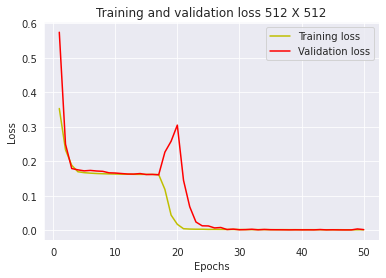

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss 512 X 512')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
# plt.savefig('Prima512DCTLoss.png',dpi=300)
plt.show()

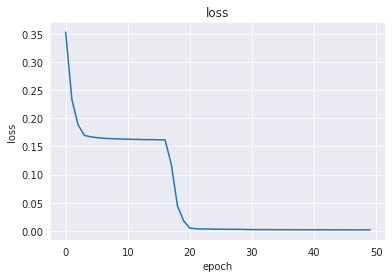

In [16]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# testX = []
# testY = []
# original=[]
# fileNameArr = []
# for fileName in val_dct_ids:
#     img = Image.open('./train',fileName).convert("L").resize((1024,1024))
#     img = np.array(img)
#     mask = Image.open(path.join('./train_cleaned',fileName)).convert('L')
#     mask = np.array(mask)
#     mask = cv2.resize(mask,(1024,1024),interpolation = cv2.INTER_NEAREST)
#     testX.append(dctImage(img))
#     testY.append(mask)
#     original.append(img)


# testX = np.array(testX)
# testY = np.array(testY)
# original = np.array(original)

In [17]:
from tqdm import tqdm
xTest = []
yTest = []
for x,y in tqdm(valDataset) :
    for idx,_ in enumerate(x) :
        xTest.append(x[idx])
        yTest.append(y[idx])

xTest = np.array(xTest)
yTest = np.array(yTest)

100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


In [18]:
predict = model.predict(xTest,batch_size=2)

In [19]:
# preFil = predict>=0.8
preFil = predict


In [ ]:
# fig,axs = plt.subplots(22,3,figsize=(20,132))
# for idx in range(22):
#     axs[idx][0].imshow(np.uint8(xTest[idx][:,:,0]),cmap='gray')
#     axs[idx][1].imshow(yTest[idx][:,:,0],cmap='gray')
#     axs[idx][2].imshow(preFil[idx][:,:,0],cmap='gray')

# fig.savefig('result.png',dpi=300)

# SNR Calculation

In [20]:
sigma = [10,20,30,40,50]
bm3d = [34.28, 28.79,25.40, 22.90, 20.20]
ssda = [34.23, 29.12, 26.61, 22.99, 20.68]
red30 = [34.41, 20.86, 27.87, 26.01, 25.44]
dcnp = [34.91, 31.28, 28.04, 26.88, 26.25]
ours = [35.14, 31.77, 28.93, 27.49, 26.57]

In [21]:
def PSNR(mean, sigma):
#     psnr = 20 * log10(255 / sqrt((mean ** 2)))
    psnr = mean / sigma
#     psnr = psnr/sigma
    return psnr

psnrOursResult = []
meanArray = []
preFil[0][:,:,0]
for indexTest in range(len(preFil)):
#     meanArray.append(np.mean(xTest[indexTest][:,:,0] - preFil[indexTest][:,:,0]))
#     meanArray.append(np.mean(xTest[indexTest][:,:,0]))
    meanArray.append(np.mean(preFil[indexTest][:,:,0]))
meanTotal = np.mean(meanArray)
for indexSigma in range(len(sigma)):
    psnrOursResult.append((PSNR(meanTotal, sigma[indexSigma]) * 100))
print(psnrOursResult)
        

[8.425914645195007, 4.212957322597504, 2.8086382150650024, 2.106478661298752, 1.6851829290390017]


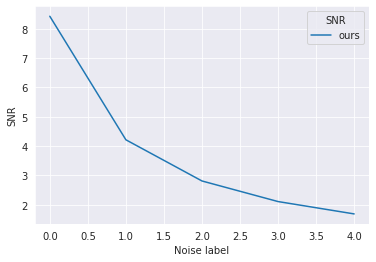

In [22]:
import matplotlib.pyplot as plt
g = sns.lineplot( 
#     data = [bm3d,ssda,red30,dcnp,ours],      
#     data = [bm3d,ssda,red30,dcnp,psnrOursResult],      
    data = [psnrOursResult],      
)
plt.legend(title='SNR', loc='upper right', labels = ["ours"])
# plt.legend(title='PSNR', loc='upper right', labels = ["bm3d","ssda","red30","dcnp","ours"])
# plt.title('')
plt.ylabel('SNR')
plt.xlabel('Noise label')
plt.savefig('SNR.png')
plt.show(g)

# PSNR calculcation

In [23]:
from math import log10, sqrt
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
psnrOurs = []
for idx in range(len(yTest)):
     psnrOurs.append(PSNR(preFil[:,:,0], yTest[idx][:,:,0]))
print(psnrOurs)

[58.88236953902786, 60.411865429890774, 60.23118529841692, 60.26951776959413, 58.71716738913829, 59.46258939643756, 59.80418948258807, 59.46324975340539, 60.5394137839481, 58.540434824395795, 60.09324342977018, 58.71716738913829, 58.55065550663636, 60.91505995059954, 58.81887808636413, 58.71716738913829, 58.55065550663636, 60.09324342977018, 59.69802519409761, 59.6928410631212, 59.46258939643756, 58.423387948610916]


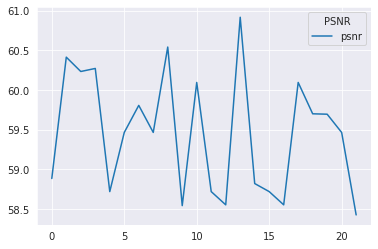

In [24]:
g = sns.lineplot( 
    data = [psnrOurs],      
)
plt.legend(title='PSNR', loc='upper right', labels = ["psnr"])
plt.show(g)